In [54]:
import pandas as pd
import glob
import numpy as np
from xfeat import SelectCategorical, LabelEncoder, LambdaEncoder, Pipeline, ConcatCombination, SelectNumerical, \
    ArithmeticCombinations, TargetEncoder, aggregation, GBDTFeatureSelector, GBDTFeatureExplorer

In [55]:
#ファイル読み込み
df = pd.DataFrame()
for i in glob.glob("train/*.csv*"):
    tmp_df=pd.read_csv(i)
    df = pd.concat([df, tmp_df],ignore_index=True)

C:\Users\osako\AppData\Local\Temp\ipykernel_1948\132664144.py:4: DtypeWarning: Columns (10) have mixed types. Specify dtype option on import or set low_memory=False.
  tmp_df=pd.read_csv(i)
C:\Users\osako\AppData\Local\Temp\ipykernel_1948\132664144.py:4: DtypeWarning: Columns (10) have mixed types. Specify dtype option on import or set low_memory=False.
  tmp_df=pd.read_csv(i)
C:\Users\osako\AppData\Local\Temp\ipykernel_1948\132664144.py:4: DtypeWarning: Columns (10) have mixed types. Specify dtype option on import or set low_memory=False.
  tmp_df=pd.read_csv(i)
C:\Users\osako\AppData\Local\Temp\ipykernel_1948\132664144.py:4: DtypeWarning: Columns (10) have mixed types. Specify dtype option on import or set low_memory=False.
  tmp_df=pd.read_csv(i)


In [56]:
#欠損値確認,欠損値削除
df_rownum=df.shape[0]
df_null_column=df.columns[df.isnull().sum()==df_rownum]
df=df.drop(df_null_column,axis=1)

In [57]:
df.drop(['ID',
         '種類',
#                '地区名',
#                '最寄駅：名称',
        '市区町村コード',
#                '用途',
#                '市区町村名',
#                '間取り',
#                '建物の構造',
#                '都市計画'
              ],inplace=True,axis=1)
df["取引の事情等"].fillna(0, inplace=True)
df.loc[df["取引の事情等"] != 0, "取引の事情等"] = 1

In [58]:
#欠損値の多い列を削除
df=df.drop(['今後の利用目的'],axis=1)
#各列のユニークな値を抽出
unique_value=df.apply(pd.Series.unique)
# print(unique_value['都道府県名'])
df.sort_values('取引時点', inplace=True)
df.reset_index(drop=True, inplace=True)

In [59]:
df_edit1=df.copy()
df_edit1.dropna(inplace=True)
df_edit1.reset_index(drop=True, inplace=True)

In [60]:
val_min_idx = min(df_edit1[df_edit1['取引時点'].str.contains('2021年第4四半期|2022年第1四半期', regex=True)].index)
# test_min_idx = min(df[df['取引時点'].str.contains('2022年第2四半期|2022年第3四半期', regex=True)].index)
val_min_idx
# test_min_idx

547549

In [61]:
enc_dic = {}
for i, e in enumerate(sorted(list(set(df['取引時点'].values)))):
    enc_dic[e] = i
df_edit1['取引時点_enc'] = df_edit1['取引時点'].map(enc_dic)

In [62]:
TARGET = '取引価格（総額）_log'
te_dic = {}
time_col = '取引時点_enc'
group_col = '都道府県名'

for i in set(df_edit1[time_col].values):
    #'取引時点_encがiより小さい行だけ取り出されている
    #各年の四半期までの平均ではなく、その時点までの平均を計算しています。
    tmp_df = df_edit1[df_edit1[time_col] < i]
    te_dic[i] = tmp_df.groupby(group_col)[TARGET].agg('mean').to_dict()


In [63]:
#編集
TARGET = '取引価格（総額）_log'
te_dic = {}
time_col = '取引時点_enc'
group_col = '市区町村名'

for i in set(df_edit1[time_col].values):
    #'取引時点_encがiより小さい行だけ取り出されている
    #各年の四半期までの平均ではなく、その時点までの平均を計算しています。
    tmp_df = df_edit1[df_edit1[time_col] < i]
    te_dic[i] = tmp_df.groupby(group_col)[TARGET].agg('mean').to_dict()

In [64]:
TARGET = '取引価格（総額）_log'
time_col = '取引時点_enc'
group_col = '都道府県名'
def calc_te(row):
    #辞書の中のdfの'取引時点_enc'かつ四半期の都道府県
    if row[time_col] in te_dic and row[group_col] in te_dic[row[time_col]]:
        return te_dic[row[time_col]][row[group_col]]
    else:
        return 0

df_edit1[group_col+'_te'] = df_edit1.apply(calc_te, axis=1)
# df_edit1.head(2)

In [65]:
TARGET = '取引価格（総額）_log'
time_col = '取引時点_enc'
group_col = '市区町村名'
def calc_te(row):
    #辞書の中のdfの'取引時点_enc'かつ四半期の都道府県
    if row[time_col] in te_dic and row[group_col] in te_dic[row[time_col]]:
        return te_dic[row[time_col]][row[group_col]]
    else:
        return 0

df_edit1[group_col+'_te'] = df_edit1.apply(calc_te, axis=1)
# df_edit1.head(2)

In [66]:
df_edit1.loc[df_edit1['建築年']=='戦前','建築年']='昭和20年'
df_edit1['和暦名称']=df_edit1['建築年'].str[:2]
df_edit1['西暦']=df_edit1['建築年'].str[2:-1]
df_edit1['西暦'].unique()
df_edit1['西暦']=df_edit1['西暦'].astype(float)
# print(df_edit1['西暦'].unique())
df_edit1.loc[df_edit1['和暦名称']=='昭和','西暦']+=1925
df_edit1.loc[df_edit1['和暦名称']=='平成','西暦']+=1988
df_edit1.loc[df_edit1['和暦名称']=='令和','西暦']+=2018
# print(df_edit1)
df_edit1.drop(['和暦名称','建築年'],inplace=True,axis=1)
df_edit1.loc[df_edit1['最寄駅：距離（分）']=='30分?60分','最寄駅：距離（分）']=45
df_edit1.loc[df_edit1['最寄駅：距離（分）']=='1H?1H30','最寄駅：距離（分）']=75
df_edit1.loc[df_edit1['最寄駅：距離（分）']=='1H30?2H','最寄駅：距離（分）']=105
df_edit1.loc[df_edit1['最寄駅：距離（分）']=='2H?','最寄駅：距離（分）']=120
df_edit1['取引時点年数']=df_edit1['取引時点'].str[:4]
df_edit1['四半期']=df_edit1['取引時点'].str[5:]
df_edit1.loc[df_edit1['四半期']=='第2四半期','取引時点年数']+='.25'
df_edit1.loc[df_edit1['四半期']=='第3四半期','取引時点年数']+='.5'
df_edit1.loc[df_edit1['四半期']=='第4四半期','取引時点年数']+='.75'
df_edit1.drop(['取引時点'],
#                '四半期'],
              inplace=True,axis=1)

In [67]:
df_edit1.loc[df_edit1['面積（㎡）']=='2000㎡以上','面積（㎡）']='2000'
df_edit1['最寄駅：距離（分）']=df_edit1['最寄駅：距離（分）'].astype(float)
df_edit1['面積（㎡）']=df_edit1['面積（㎡）'].astype(int)
df_edit1['西暦']=df_edit1['西暦'].astype(float)
df_edit1['取引時点年数']=df_edit1['取引時点年数'].astype(float)
df_edit1['容積率（％）']=df_edit1['容積率（％）'].astype(float)
df_edit1['建ぺい率（％）']=df_edit1['建ぺい率（％）'].astype(float)
df_edit1['取引価格（総額）_log']=df_edit1['取引価格（総額）_log'].astype(float)

In [68]:
df_test=df_edit1['取引価格（総額）_log']
df_edit1.drop('取引価格（総額）_log',inplace=True,axis=1)

In [69]:
agg_dfs = []

def get_agg_df(df, group_col):

    agg_df, agg_cols = aggregation(df_edit1,
                        group_key=group_col,
                        group_values=['最寄駅：距離（分）', '面積（㎡）', '建ぺい率（％）', '容積率（％）'],
                        agg_methods=['count', 'mean', 'min', 'max'],
                        )

    return agg_df[agg_cols]

group_col = '市区町村名'
agg_dfs.append(get_agg_df(df_edit1, group_col))
agg_dfs[0].head(2)

,agg_count_最寄駅：距離（分）_grpby_市区町村名,agg_count_面積（㎡）_grpby_市区町村名,agg_count_建ぺい率（％）_grpby_市区町村名,agg_count_容積率（％）_grpby_市区町村名,agg_mean_最寄駅：距離（分）_grpby_市区町村名,agg_mean_面積（㎡）_grpby_市区町村名,agg_mean_建ぺい率（％）_grpby_市区町村名,agg_mean_容積率（％）_grpby_市区町村名,agg_min_最寄駅：距離（分）_grpby_市区町村名,agg_min_面積（㎡）_grpby_市区町村名,agg_min_建ぺい率（％）_grpby_市区町村名,agg_min_容積率（％）_grpby_市区町村名,agg_max_最寄駅：距離（分）_grpby_市区町村名,agg_max_面積（㎡）_grpby_市区町村名,agg_max_建ぺい率（％）_grpby_市区町村名,agg_max_容積率（％）_grpby_市区町村名
0,7419,7419,7419,7419,7.440221,47.131015,66.953767,297.484836,0.0,10,40.0,80.0,120.0,155,80.0,800.0
1,5891,5891,5891,5891,5.372433,41.398744,74.041759,462.705822,0.0,10,60.0,100.0,20.0,1300,80.0,600.0


In [70]:
agg_dfs2 = []

def get_agg_df(df, group_col):

    agg_df, agg_cols = aggregation(df_edit1,
                        group_key=group_col,
                        group_values=['最寄駅：距離（分）', '面積（㎡）', '建ぺい率（％）', '容積率（％）'],
                        agg_methods=['count', 'mean', 'min', 'max'],
                        )

    return agg_df[agg_cols]

group_col = '地区名'
agg_dfs2.append(get_agg_df(df_edit1, group_col))
agg_dfs2[0].head(2)

,agg_count_最寄駅：距離（分）_grpby_地区名,agg_count_面積（㎡）_grpby_地区名,agg_count_建ぺい率（％）_grpby_地区名,agg_count_容積率（％）_grpby_地区名,agg_mean_最寄駅：距離（分）_grpby_地区名,agg_mean_面積（㎡）_grpby_地区名,agg_mean_建ぺい率（％）_grpby_地区名,agg_mean_容積率（％）_grpby_地区名,agg_min_最寄駅：距離（分）_grpby_地区名,agg_min_面積（㎡）_grpby_地区名,agg_min_建ぺい率（％）_grpby_地区名,agg_min_容積率（％）_grpby_地区名,agg_max_最寄駅：距離（分）_grpby_地区名,agg_max_面積（㎡）_grpby_地区名,agg_max_建ぺい率（％）_grpby_地区名,agg_max_容積率（％）_grpby_地区名
0,446,446,446,446,15.343049,64.607623,59.618834,200.000000,4.0,15,50.0,200.0,45.0,105,60.0,200.0
1,661,661,661,661,6.384266,45.741301,69.016641,457.488654,0.0,15,60.0,200.0,13.0,180,80.0,600.0


In [71]:
# agg_dfs3 = []

# def get_agg_df(df, group_col):

#     agg_df, agg_cols = aggregation(df,
#                         group_key=group_col,
#                         group_values=['最寄駅：距離（分）'],
#                         agg_methods=['mean'],
#                         )

#     return agg_df[agg_cols]

# group_col = '最寄駅：名称'
# agg_dfs3.append(get_agg_df(df_edit1, group_col))
# agg_dfs3[0].head(2)

In [274]:
# concat_combi = ConcatCombination(drop_origin=True, r=2)
# concat_df=concat_combi.fit_transform(df_edit1[['都道府県名', '最寄駅：距離（分）','間取り']].astype(str))
# concat_combi = ConcatCombination(drop_origin=True, r=3)
# concat_df2=concat_combi.fit_transform(df_edit1[['都道府県名', '最寄駅：距離（分）','間取り']].astype(str))
# concat_combi = ConcatCombination(drop_origin=True, r=2)
# concat_df3=concat_combi.fit_transform(df_edit1[['市区町村名', '最寄駅：距離（分）']].astype(str))
# concat_combi = ConcatCombination(drop_origin=True, r=2)
# concat_df4=concat_combi.fit_transform(df_edit1[['西暦', '最寄駅：距離（分）']].astype(str))
# concat_combi = ConcatCombination(drop_origin=True, r=2)
# concat_df5=concat_combi.fit_transform(df_edit1[['最寄駅：距離（分）', '最寄駅：名称']].astype(str))
# concat_combi = ConcatCombination(drop_origin=True, r=3)
# concat_df6=concat_combi.fit_transform(df_edit1[['西暦', '取引時点年数','都道府県名','市区町村名']].astype(str))
# concat_combi = ConcatCombination(drop_origin=True, r=2)
# concat_df3=concat_combi.fit_transform(df_edit1[['都道府県名', '西暦']].astype(str))
concat_combi = ConcatCombination(drop_origin=True, r=2)
concat_df=concat_combi.fit_transform(df_edit1[['最寄駅：距離（分）', '面積（㎡）']].astype(str))

In [530]:
#### ArithmeticCombinationsの適用
arithmetic_combinations = ArithmeticCombinations(
    operator='*',
    drop_origin=True,  
    # 元の特徴量を削除するかどうか

    # 使用する算術演算子
    r=2,
    # 算術演算子の数（ここでは2つの特徴量を組み合わせる）
)
output_df = arithmetic_combinations.fit_transform(df_edit1[['市区町村名_te', '面積（㎡）']])
# ArithmeticCombinationsの適用
arithmetic_combinations = ArithmeticCombinations(
    operator='/',
    drop_origin=True,  
    # 元の特徴量を削除するかどうか

    # 使用する算術演算子
    r=2,
    # 算術演算子の数（ここでは2つの特徴量を組み合わせる）
)
output_df2 = arithmetic_combinations.fit_transform(df_edit1[['取引時点_enc','市区町村名_te']])

In [531]:
df_edit2=pd.concat([df_edit1,output_df,
#                     output_df2
#                   concat_df
                   ]
#                    concat_df2,concat_df3,concat_df4,concat_df5,concat_df6]
                   +agg_dfs+agg_dfs2,axis=1)
# print(feat_df.shape)

In [532]:
output_df2

,取引時点_enc市区町村名_te_combi
0,NaN
1,NaN
2,NaN
3,NaN
4,NaN
...,...
564688,9.029905
564689,10.185127
564690,8.791727
564691,9.282874


In [533]:
encoder = Pipeline([
    SelectCategorical(),
    LabelEncoder(output_suffix=""),
])
le_df = encoder.fit_transform(df_edit2)
le_df.head(2)

c:\users\osako\pycharmprojects\pythonproject2\venv\lib\site-packages\xfeat\cat_encoder\_basic_encoder.py:93: FutureWarning: In a future version, the Index constructor will not infer numeric dtypes when passed object-dtype sequences (matching Series behavior)
  labels, uniques = input_df[col].factorize(sort=self._sort_category)


,都道府県名,市区町村名,地区名,最寄駅：名称,間取り,建物の構造,用途,都市計画,改装,取引の事情等,四半期
0,0,0,0,0,0,0,0,0,0,0,0
1,0,1,1,1,1,1,0,1,1,0,0


In [534]:
encoder = Pipeline(
    [
        SelectNumerical(),
    ]
)

num_comb_df = encoder.fit_transform(df_edit2)
num_comb_df.head(2)

,最寄駅：距離（分）,面積（㎡）,建ぺい率（％）,容積率（％）,取引時点_enc,都道府県名_te,市区町村名_te,西暦,取引時点年数,市区町村名_te面積（㎡）_combi,...,agg_mean_建ぺい率（％）_grpby_地区名,agg_mean_容積率（％）_grpby_地区名,agg_min_最寄駅：距離（分）_grpby_地区名,agg_min_面積（㎡）_grpby_地区名,agg_min_建ぺい率（％）_grpby_地区名,agg_min_容積率（％）_grpby_地区名,agg_max_最寄駅：距離（分）_grpby_地区名,agg_max_面積（㎡）_grpby_地区名,agg_max_建ぺい率（％）_grpby_地区名,agg_max_容積率（％）_grpby_地区名
0,12.0,70,60.0,200.0,0,0,0.0,1978.0,2005.5,0.0,...,59.618834,200.000000,4.0,15,50.0,200.0,45.0,105,60.0,200.0
1,11.0,20,80.0,600.0,0,0,0.0,2005.0,2005.5,0.0,...,69.016641,457.488654,0.0,15,60.0,200.0,13.0,180,80.0,600.0


In [535]:
df_dummy=pd.concat([num_comb_df,le_df],axis=1)

In [536]:
# from sklearn.preprocessing import OrdinalEncoder
# oe = OrdinalEncoder()

# labels = df_edit1[[
# #     '市区町村コード',
#     '都道府県名',
#     '市区町村名',
#     '最寄駅：名称',
#      '間取り',
#      '建物の構造',
#     '地区名',
#      '用途',
#     '都市計画',
#     '四半期',
#     '改装']].values
# labels_id = oe.fit_transform(labels)
# # df_dummy = pd.concat([df_edit1, labels_id], axis=1)
# # df_dummy.drop(['都道府県名', 
# #                '市区町村名',
# #                '間取り',
# #                 '建物の構造',
# #                 '都市計画',
# #                '改装'],axis=1,inplace=True)
# df_dummy = pd.concat([df_edit1.reset_index(drop=True), pd.DataFrame(labels_id)], axis=1)
# df_dummy.drop(['都道府県名',
#                '市区町村名', 
#                '四半期',
#                '間取り', 
#                '建物の構造', 
#                '都市計画',
#                '最寄駅：名称',
#                '地区名',
#                '用途',
#                '改装'], axis=1, inplace=True)
# print(labels_id.shape) 

In [537]:
# df_dummy['面積（㎡）log']=np.log(df_dummy['面積（㎡）'])
# df_dummy['面積（㎡）log'].replace([np.inf, -np.inf], np.nan, inplace=True)
# df_dummy['面積（㎡）log'].fillna(0,inplace=True)

In [538]:
# df_dummy['最寄駅：距離（分）log']=np.log(df_dummy['最寄駅：距離（分）'])
# df_dummy['最寄駅：距離（分）log'].replace([np.inf, -np.inf], np.nan, inplace=True)
# df_dummy['最寄駅：距離（分）log'].fillna(0,inplace=True)

In [539]:
df_dummy['建ぺい率×容積率']=df_dummy['建ぺい率（％）']*df_dummy['容積率（％）']
df_dummy['敷地面積']=df_dummy['面積（㎡）']/df_dummy['建ぺい率（％）']*100
df_dummy['延べ床面積']=df_dummy['容積率（％）']/100*df_dummy['敷地面積']
df_dummy['年差']=df_dummy['西暦']-df_dummy['取引時点年数']
df_dummy.isnull().sum()

最寄駅：距離（分）                          0
面積（㎡）                              0
建ぺい率（％）                            0
容積率（％）                             0
取引時点_enc                           0
都道府県名_te                           0
市区町村名_te                           0
西暦                                 0
取引時点年数                             0
市区町村名_te面積（㎡）_combi                0
agg_count_最寄駅：距離（分）_grpby_市区町村名    0
agg_count_面積（㎡）_grpby_市区町村名        0
agg_count_建ぺい率（％）_grpby_市区町村名      0
agg_count_容積率（％）_grpby_市区町村名       0
agg_mean_最寄駅：距離（分）_grpby_市区町村名     0
agg_mean_面積（㎡）_grpby_市区町村名         0
agg_mean_建ぺい率（％）_grpby_市区町村名       0
agg_mean_容積率（％）_grpby_市区町村名        0
agg_min_最寄駅：距離（分）_grpby_市区町村名      0
agg_min_面積（㎡）_grpby_市区町村名          0
agg_min_建ぺい率（％）_grpby_市区町村名        0
agg_min_容積率（％）_grpby_市区町村名         0
agg_max_最寄駅：距離（分）_grpby_市区町村名      0
agg_max_面積（㎡）_grpby_市区町村名          0
agg_max_建ぺい率（％）_grpby_市区町村名        0
agg_max_容積率（％）_grpby_市区町村名         0
agg_count_最寄駅：距離（分）_grpby_地区名      0
a

In [540]:
df_dummy.columns = df_dummy.columns.astype(str)

In [541]:
df_dummy.drop(df_dummy[['agg_count_容積率（％）_grpby_市区町村名','agg_count_面積（㎡）_grpby_市区町村名','agg_count_建ぺい率（％）_grpby_市区町村名','取引時点年数','四半期',
                        'agg_count_容積率（％）_grpby_地区名',
                        'agg_count_建ぺい率（％）_grpby_地区名',
                        '都道府県名_te']],axis=1,inplace=True)

In [542]:
X_train=df_dummy.iloc[:val_min_idx,:]
y_train=df_test.iloc[:val_min_idx]
X_test=df_dummy.iloc[val_min_idx:,:]
y_test=df_test.iloc[val_min_idx:]

In [543]:
X_test.isnull().sum()

最寄駅：距離（分）                          0
面積（㎡）                              0
建ぺい率（％）                            0
容積率（％）                             0
取引時点_enc                           0
市区町村名_te                           0
西暦                                 0
市区町村名_te面積（㎡）_combi                0
agg_count_最寄駅：距離（分）_grpby_市区町村名    0
agg_mean_最寄駅：距離（分）_grpby_市区町村名     0
agg_mean_面積（㎡）_grpby_市区町村名         0
agg_mean_建ぺい率（％）_grpby_市区町村名       0
agg_mean_容積率（％）_grpby_市区町村名        0
agg_min_最寄駅：距離（分）_grpby_市区町村名      0
agg_min_面積（㎡）_grpby_市区町村名          0
agg_min_建ぺい率（％）_grpby_市区町村名        0
agg_min_容積率（％）_grpby_市区町村名         0
agg_max_最寄駅：距離（分）_grpby_市区町村名      0
agg_max_面積（㎡）_grpby_市区町村名          0
agg_max_建ぺい率（％）_grpby_市区町村名        0
agg_max_容積率（％）_grpby_市区町村名         0
agg_count_最寄駅：距離（分）_grpby_地区名      0
agg_count_面積（㎡）_grpby_地区名          0
agg_mean_最寄駅：距離（分）_grpby_地区名       0
agg_mean_面積（㎡）_grpby_地区名           0
agg_mean_建ぺい率（％）_grpby_地区名         0
agg_mean_容積率（％）_grpby_地区名          0
a

In [544]:
X_test

,最寄駅：距離（分）,面積（㎡）,建ぺい率（％）,容積率（％）,取引時点_enc,市区町村名_te,西暦,市区町村名_te面積（㎡）_combi,agg_count_最寄駅：距離（分）_grpby_市区町村名,agg_mean_最寄駅：距離（分）_grpby_市区町村名,...,間取り,建物の構造,用途,都市計画,改装,取引の事情等,建ぺい率×容積率,敷地面積,延べ床面積,年差
547549,16.0,70,60.0,200.0,65,7.093400,2001.0,496.538006,1100,14.216364,...,0,1,0,0,0,0,12000.0,116.666667,233.333333,-20.75
547550,4.0,70,60.0,200.0,65,7.367739,1974.0,515.741720,11514,7.152857,...,0,1,0,4,0,0,12000.0,116.666667,233.333333,-47.75
547551,13.0,75,80.0,300.0,65,7.171199,2012.0,537.839929,1073,10.933830,...,0,1,0,2,0,0,24000.0,93.750000,281.250000,-9.75
547552,45.0,110,60.0,300.0,65,7.154824,2007.0,787.030654,2094,15.596944,...,9,1,0,0,0,0,18000.0,183.333333,550.000000,-14.75
547553,5.0,55,80.0,500.0,65,7.367739,1984.0,405.225637,11514,7.152857,...,3,0,0,1,0,0,40000.0,68.750000,343.750000,-37.75
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
564688,18.0,85,60.0,200.0,66,7.309047,2021.0,621.269027,4359,12.079147,...,9,1,0,0,1,0,12000.0,141.666667,283.333333,-1.00
564689,25.0,25,60.0,200.0,66,6.480037,1974.0,162.000918,290,35.565517,...,1,0,0,9,1,0,12000.0,41.666667,83.333333,-48.00
564690,2.0,25,80.0,300.0,66,7.507058,2011.0,187.676439,9650,8.885078,...,1,1,0,2,1,0,24000.0,31.250000,93.750000,-11.00
564691,13.0,55,60.0,200.0,66,7.109867,1982.0,391.042702,522,24.111111,...,3,1,0,8,0,0,12000.0,91.666667,183.333333,-40.00


In [545]:
import xgboost as xgb
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Ridge, Lasso
from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np

xgb_r = xgb.XGBRegressor(objective='reg:linear',
                         learning_rate=0.3,
                         reg_lambda=1,
                         n_estimators=400,
                         early_stopping_rounds=20,
                         max_depth=8,
                         seed=123)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Train the XGBoost model with early stopping
xgb_r.fit(X_train_scaled, y_train, eval_set=[(X_test_scaled, y_test)], verbose=True)

y_pred_train = xgb_r.predict(X_train_scaled)
mse_train = mean_squared_error(y_train, y_pred_train)
rmse_train = np.sqrt(mse_train)
print("Train RMSE:", rmse_train)

y_pred_test = xgb_r.predict(scaler.transform(X_test))
mse_test = mean_squared_error(y_test, y_pred_test)
rmse_test = np.sqrt(mse_test)
mae_test = mean_absolute_error(y_test, y_pred_test)
print("Test RMSE:", rmse_test)
print("Test MAE:", mae_test)

[03:44:08] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07593ffd91cd9da33-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-rmse:4.82214
[1]	validation_0-rmse:3.39645
[2]	validation_0-rmse:2.39804
[3]	validation_0-rmse:1.69807
[4]	validation_0-rmse:1.20728
[5]	validation_0-rmse:0.86383
[6]	validation_0-rmse:0.62591
[7]	validation_0-rmse:0.46025
[8]	validation_0-rmse:0.34832
[9]	validation_0-rmse:0.27400
[10]	validation_0-rmse:0.22339
[11]	validation_0-rmse:0.19211
[12]	validation_0-rmse:0.17282
[13]	validation_0-rmse:0.16058
[14]	validation_0-rmse:0.15095
[15]	validation_0-rmse:0.14640
[16]	validation_0-rmse:0.14303
[17]	validation_0-rmse:0.14097
[18]	validation_0-rmse:0.13951
[19]	validation_0-rmse:0.13784
[20]	validation_0-rmse:0.13692
[21]	validation_0-rmse:0.13614
[22]	validation_0-rmse:0.13551
[23]	validation_0-rmse:0.13498
[24]	validation_0-rmse:0.13421
[25]


KeyboardInterrupt



In [212]:
# importance_scores = xgb_r.feature_importances_
# feature_names = X_train.columns

# # Display feature importance
# for feature_name, importance_score in zip(feature_names, importance_scores):
#     print(feature_name, importance_score)


In [213]:
# importance_scores = xgb_r.get_booster().get_score(importance_type='weight')
# # 特徴量の重要度を表示
# for feature_name, importance_score in importance_scores.items():
#     print(feature_name, importance_score)


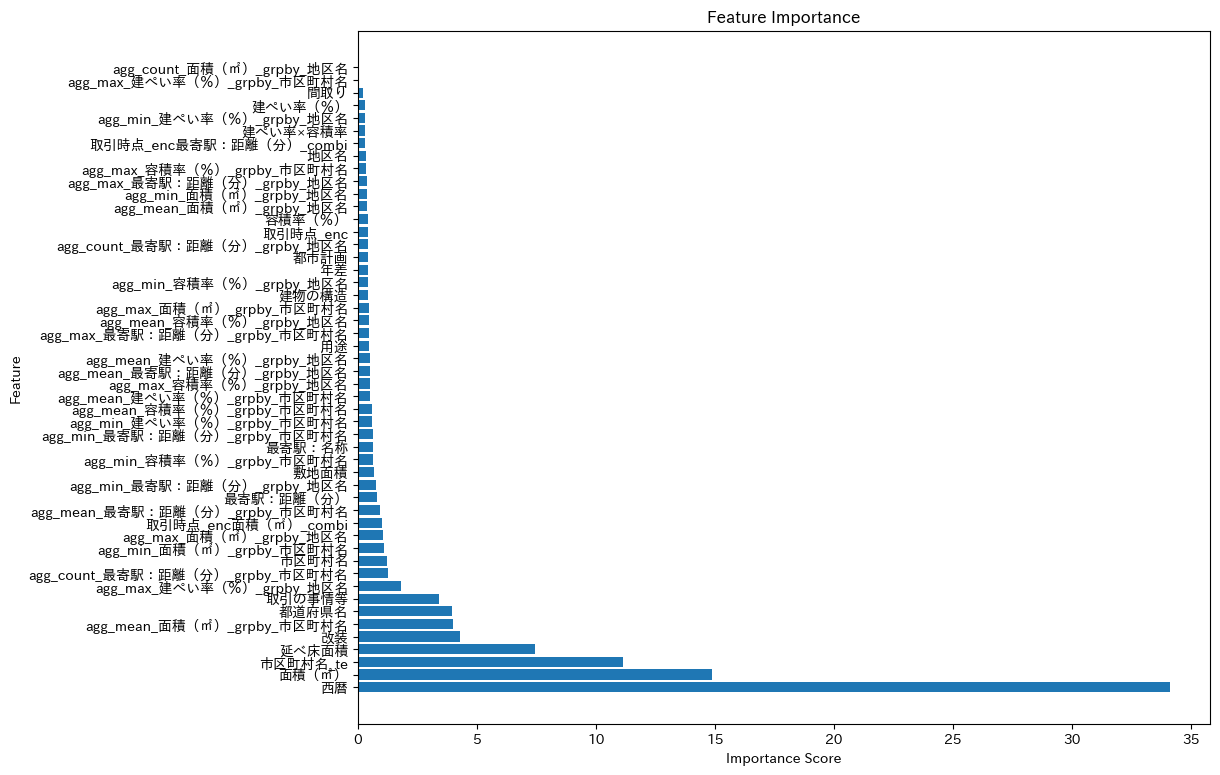

In [222]:
import matplotlib.pyplot as plt
import japanize_matplotlib

importance_scores = xgb_r.get_booster().get_score(importance_type='gain')
feature_names = X_train.columns

importance_values = [importance_scores.get('f{}'.format(i), 0) for i in range(len(feature_names))]

# 重要度の値で降順にソート
sorted_indices = sorted(range(len(importance_values)), key=lambda k: importance_values[k], reverse=True)
importance_values_sorted = [importance_values[i] for i in sorted_indices]
feature_names_sorted = [feature_names[i] for i in sorted_indices]

plt.figure(figsize=(11, 9))
plt.barh(range(len(importance_values_sorted)), importance_values_sorted, align='center')
plt.yticks(range(len(importance_values_sorted)), feature_names_sorted)
plt.xlabel('Importance Score')
plt.ylabel('Feature')
plt.title('Feature Importance')
plt.show()


In [31]:
X_train

,最寄駅：距離（分）,面積（㎡）,容積率（％）,取引時点_enc,都道府県名_te,西暦,取引時点年数,agg_count_最寄駅：距離（分）_grpby_市区町村名,agg_count_面積（㎡）_grpby_市区町村名,agg_count_建ぺい率（％）_grpby_市区町村名,...,用途,都市計画,改装,取引の事情等,面積（㎡）log,最寄駅：距離（分）log,建ぺい率×容積率,敷地面積,延べ床面積,年差
0,12.0,70,200.0,0,0.000000,1978.0,2005.5,7419,7419,7419,...,0,0,0,0,4.248495,2.484907,12000.0,116.666667,233.333333,-27.5
1,11.0,20,600.0,0,0.000000,2005.0,2005.5,5891,5891,5891,...,0,1,1,0,2.995732,2.397895,48000.0,25.000000,150.000000,-0.5
2,8.0,20,600.0,0,0.000000,1989.0,2005.5,6167,6167,6167,...,0,1,1,0,2.995732,2.079442,48000.0,25.000000,150.000000,-16.5
3,14.0,20,300.0,0,0.000000,1998.0,2005.5,6875,6875,6875,...,0,2,1,0,2.995732,2.639057,24000.0,25.000000,75.000000,-7.5
4,10.0,60,200.0,0,0.000000,1984.0,2005.5,1318,1318,1318,...,0,3,0,0,4.094345,2.302585,12000.0,100.000000,200.000000,-21.5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
547544,3.0,75,150.0,64,7.274751,1998.0,2021.5,1561,1561,1561,...,0,0,1,0,4.317488,1.098612,9000.0,125.000000,187.500000,-23.5
547545,28.0,55,200.0,64,7.274751,1971.0,2021.5,2627,2627,2627,...,0,0,1,0,4.007333,3.332205,12000.0,91.666667,183.333333,-50.5
547546,3.0,85,300.0,64,7.187452,2009.0,2021.5,763,763,763,...,0,4,1,0,4.442651,1.098612,18000.0,141.666667,425.000000,-12.5
547547,45.0,65,200.0,64,7.406143,1998.0,2021.5,4051,4051,4051,...,0,0,1,0,4.174387,3.806662,12000.0,108.333333,216.666667,-23.5


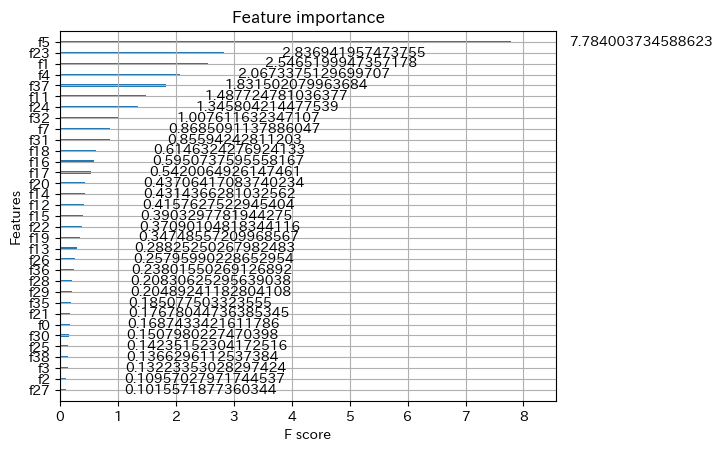

In [107]:
import matplotlib.pyplot as plt
import japanize_matplotlib
xgb.plot_importance(xgb_r,importance_type='gain')
plt.show()

<Axes: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

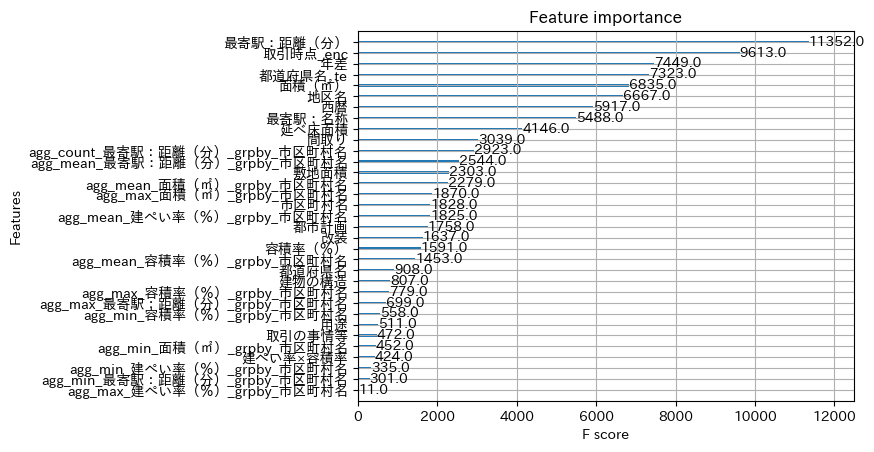

In [112]:
features =df_dummy.columns[df_dummy.any()]
mapper = {'f{0}'.format(i): v for i, v in enumerate(features)}
mapped = {mapper[k]: v for k, v in xgb_r._Booster.get_fscore().items()}
xgb.plot_importance(mapped,importance_type='cover')

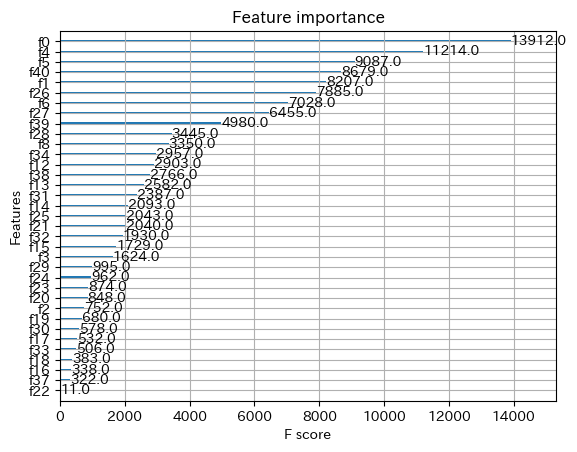

In [100]:
import matplotlib.pyplot as plt
import japanize_matplotlib
xgb.plot_importance(xgb_r,importance_type='weight')
plt.show()

In [ ]:
import xgboost as xgb
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np

xgb_r = xgb.XGBRegressor(objective='reg:linear',
                         learning_rate=0.3, 
                         reg_lambda=1,
                         n_estimators=400,
                         max_depth=8,
                         seed=123)
xgb_r.fit(X_train, y_train, 
         eval_set=[(X_test, y_test)],
         early_stopping_rounds=20)

In [ ]:
# K分割交差検証
from sklearn.model_selection import KFold
 sklearn.model_selection import KFold
# データの分割
kf = KFold(n_splits=5, shuffle=True, random_state=42)
valid_mse = []
i = 1
for train_id, test_id in kf.split(X_set):
   # モデルの学習
    pipe.fit(X_train, y_train)
    # テストデータの予測値とMSEの計算
    y_pred_test = pipe.predict(X_test)
    test_mse = mean_squared_error(y_test, y_pred_test)
    # テストデータでのRMSE
    print('{}Fold テストRMSE: {}'.format(i, np.sqrt(test_mse)))  # 各Kの誤差を表示
    valid_mse.append(np.sqrt(test_mse))  # 各KのテストMSEの平均が検証誤差
    i += 1

In [ ]:
import matplotlib.pyplot as plt
import japanize_matplotlib
xgb.plot_importance(xgb_r)
plt.show()

In [ ]:
from sklearn.model_selection import GridSearchCV
best_model

In [ ]:

import xgboost as xgb
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import make_scorer, mean_absolute_error
from itertools import product

# Define the hyperparameter combinations
param_grid = {
    'learning_rate': [0.3, 0.6, 1],
    'max_depth': [6, 8, 11],
    'reg_lambda': [0.5, 1],
    'n_estimators': [300],
    'subsample': [0.6, 1],
    'colsample_bytree': [0.6, 1],
#     'min_child_weight': [1, 5]
}


# Initialize the best model, best parameters, and best accuracy
best_model = None
best_params = None
best_mae = float('inf') 

# Hyperparameter tuning and model evaluation
for params in product(*param_grid.values()):
    param_dict = dict(zip(param_grid.keys(), params))
    print(param_dict)
    # Create a pipeline with feature scaling and XGBoost classifier
    pipeline = Pipeline([
        ('scaler', StandardScaler()),
        ('model', xgb.XGBRegressor(**param_dict))
    ])

    pipeline.fit(X_train, y_train)
    y_pred = pipeline.predict(X_test)
    mae = mean_absolute_error(y_test, y_pred)

    if mae < best_mae:
        best_mae = mae
        best_model = pipeline
        best_params = params

# Retrain the best model with the entire training set
# best_model.fit(X_train, y_train)

# # Evaluate the final model on the test set
# y_pred = best_model.predict(X_test)
# accuracy = accuracy_score(y_test, y_pred)
# print("Test Accuracy:", accuracy)

In [ ]:
import xgboost as xgb
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import GridSearchCV

# Define the hyperparameter combinations
param_grid = {
    'model__learning_rate': [0.3, 0.6, 1],
    'model__max_depth': [3, 6, 9, 11],
    'model__reg_lambda': [0.5, 1],
    'model__n_estimators': [200, 400, 600],
    'model__subsample': [0.5, 0.75, 1],
    'model__colsample_bytree': [0.5, 0.75, 1],
    'model__min_child_weight': [1, 5, 10],
    'model__gamma': [0, 0.1, 0.5, 1, 3]
}

# Create a pipeline with feature scaling and XGBoost regressor
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('model', xgb.XGBRegressor())
])

# Initialize GridSearchCV for hyperparameter tuning
grid_search = GridSearchCV(pipeline, param_grid, scoring='neg_mean_absolute_error', cv=5)
grid_search.fit(X_train, y_train)

# Get the best model, best parameters, and best MAE
best_model = grid_search.best_estimator_
best_params = grid_search.best_params_
# y_pred = best_model.predict(X_test)
# best_mae = mean_absolute_error(y_val, y_pred)